# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('../../Rossby_wave_test_case/MARA_RUN2_SWOT_state_2015-01-06.nc')
#state_ds #.PHIHYD #, state_ds.DRHODR

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

## Interpolate the N2 vector onto a uniform pressure grid

In [11]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [12]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [13]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform[:-16], N2_uniform[:-16]

In [14]:
import VERT_FSFB3

In [15]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [16]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [17]:
SSH = G/g

In [18]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)

In [19]:
MODE = G.shape[-1]

In [20]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

### Beta plane paramters

In [21]:
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

### SSH - 15 waves, 5 baroclinic modes, 3 wavenumbers, 5 modes, 15 frequencies, 30 amplitudes

#### The dispersion relation relates frequency to wavenumber for each mode:

In [22]:
MModes = 5 # 
wavelength = np.array([2e5, 1e5, .5e5]) # 200km, 100km, 50km
wavespeed = c2[:MModes] # Phase speed
k_n = 2 * np.pi / wavelength # wavenumber
Rm = wavespeed[:MModes] / f0 # Rossby deformation radius
wavelength_l = 0.4 * wavelength
l_n = 2 * np.pi / wavelength_l # Y direction wavenumber
freq_n = np.zeros([len(wavelength), MModes])
for nn in range(len(k_n)):
    for mm in range(MModes):
        freq_n[nn, mm] = (Beta * k_n[nn]) / (k_n[nn] ** 2 + l_n[nn] ** 2 + Rm[mm] ** (-2))
Amp = np.random.rand(2, MModes, len(wavelength))
M = Amp.size

In [23]:
X_loc = np.arange(0, 1e6, 1e4) # domain size 1000 km with 10km resolution
Y_loc = np.arange(0, 1e6, 1e4)
T_time = np.arange(0, 1e10, 1e8) # Time step : ~11days

### H Matrix and SSH

In [24]:
%%time
H_cos = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)] ) # Number of waves * Number of data
H_sin = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
SSH_XYTMN = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
for tt in range(len(T_time)):
    for xx in range(len(X_loc)):
        for yy in range(len(Y_loc)):
            for mm in range(Amp.shape[1]):
                for nn in range(len(k_n)):
                    H_cos[tt, xx, yy, mm, nn] = Psi[0, mm] * np.cos(k_n[nn] * X_loc[xx] + l_n[nn] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt]) 
                    H_sin[tt, xx, yy, mm, nn] = Psi[0, mm] * np.sin(k_n[nn] * X_loc[xx] + l_n[nn] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt])

for mm in range(MModes):
    for nn in range(len(k_n)):
        SSH_XYTMN[:, :, :, mm, nn] = Amp[0, mm, nn] * H_cos[:, :, :, mm, nn] + Amp[1, mm, nn] * H_sin[:, :, :, mm, nn]

CPU times: user 1min 5s, sys: 379 ms, total: 1min 6s
Wall time: 1min 6s


#### Add up long the last two axis: modes, frequences

In [25]:
SSH_XYT = np.sum(SSH_XYTMN, axis = (-1, -2))

### Exact-solution - Solve 30 unknow amplitudes with 30 data points.

In [26]:
a, b, c, d = 0, 1, 50, 1
x0 = np.arange(0, 50, 1)
y0 = np.arange(0, 50, 1)
xswath_index0 = a + b * x0
yswath_index0 = c + d * y0
swath_ysize = 12
yswath_index = np.ma.masked_all([12, len(yswath_index0)])
xswath_index = np.ma.masked_all([12, len(xswath_index0)])
for yy in range(1, swath_ysize):
    if(yy!= 6&7):
        yswath_index[yy] = yswath_index0 + yy
        xswath_index[yy] = xswath_index0

#### SWOT swath: two 50km swaths with 20 km gap in middle

In [27]:
yswath_index = np.ma.masked_greater_equal(yswath_index, 100)
y_mask = np.ma.getmask(yswath_index)
xswath_index = np.ma.masked_where(((yswath_index ==100)&(yswath_index>100)), xswath_index)

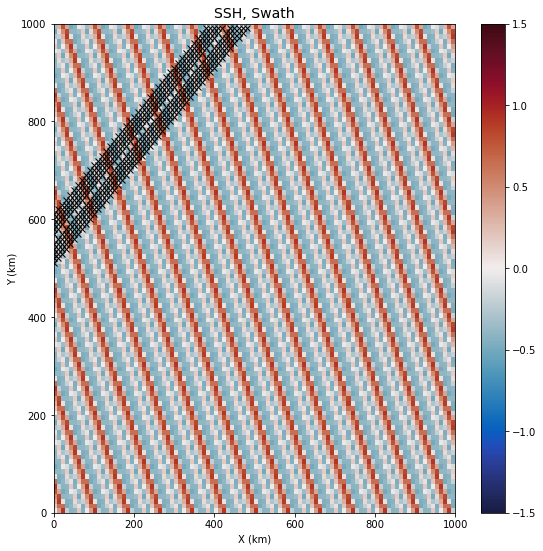

In [28]:
fig = plt.figure(figsize = (9, 9))
plt.pcolor(SSH_XYT[0], cmap = cmo.cm.balance, vmin = -1.5, vmax = 1.5)
plt.title('SSH, Swath', fontsize = 14)
for yy in range(swath_ysize):
    plt.plot(xswath_index0, yswath_index[yy] , 'x', color = 'black')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.xticks(np.arange(0, 101, 20), np.arange(0, 1001, 200))
plt.yticks(np.arange(0, 101, 20), np.arange(0, 1001, 200)) #Resolution 10 km
plt.colorbar()
plt.savefig('swath_sample.png')

#### Retrieve valid data and random sample in time 

In [69]:
yvalid_index = yswath_index.compressed().astype(int) # retrieve the valid data 
xvalid_index = xswath_index.compressed().astype(int) # retrieve the valid data 
tindex = np.random.randint(low = 0, high= 99, size= xvalid_index.size)  # Random sampling in time

In [70]:
N = yvalid_index.size
N == xvalid_index.size

True

In [71]:
H_ = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes*2, len(wavelength)]) # Number of data * Number of models
H_[:, :, :, 0::2] = H_cos #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')
H_[:, :, :, 1::2] = H_sin #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')

In [72]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v = np.zeros([N, M]) # M: number of model
nx, ny = N, N
for iii in range(N):
    #print(tindex, xswath_index[iii], yswath_index[iii])
    IIndex[iii] = nx * ny * tindex[iii] + ny * xvalid_index[iii] + yvalid_index[iii]
    Y_v[iii] = SSH_XYT[tindex[iii], xvalid_index[iii], yvalid_index[iii]]
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            H_IIndex = nx * ny * tindex[iii] + ny * xvalid_index[iii] + yvalid_index[iii] ## Data space
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[tindex[iii], xvalid_index[iii], yvalid_index[iii], mm, nn]
            H_v[iii, JIndex + 1] = H_sin[tindex[iii], xvalid_index[iii], yvalid_index[iii], mm, nn]

#### Weighted least square solution

In [73]:
num_samples = len(Y_loc)
noise_std = 2

#### R and P Matrix

In [74]:
R_ = np.eye(N, N)

In [75]:
P_ = np.eye(M, M)

In [76]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [77]:
A = np.matmul(H_v.T, LA.inv(R_))

In [78]:
HRH = np.matmul(A, H_v)

In [79]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

In [80]:
eig, vec = LA.eig(HRH)
eig.real

array([24855.04176532, 22738.13575445, 18948.38217668, 18418.49011289,
       17288.36968875, 15918.09906249,  6271.23955223,  5900.25465219,
        5796.71981673,  5295.65656619,  4897.78061116,  4134.53248309,
        4163.6295635 ,  3689.04205233,  3860.78231386,  3818.49612339,
          99.59224167,   109.57214978,  1718.14677599,  1764.34116244,
        1752.36705368,  1538.31805024,  1419.12034987,  1290.1526156 ,
         773.79741789,   728.22419516,   687.06345811,   589.51041347,
         642.64392812,   608.99954243])

#### Soution with noise

In [81]:
X_ = np.matmul(D, Y_v)

In [82]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

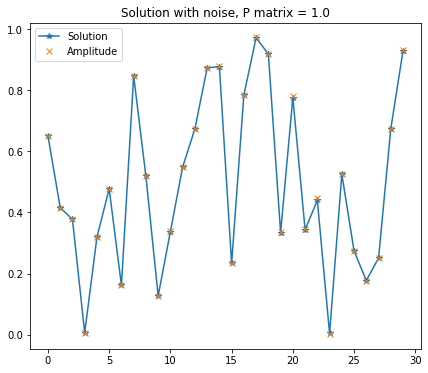

In [83]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN,'*-', label = 'Solution')
plt.plot(Amp.reshape([30], order = 'F'),'x',label = 'Amplitude')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'.png')

In [84]:
diff = SOL_WN - Amp.reshape([M], order = 'F')

In [85]:
rms = np.sqrt(np.mean(diff**2))
rms

0.0017114124811484362

#### Create simulated roll error

In [86]:
alpha2 = -.1e-4
roll_err = np.ma.masked_all(yswath_index.shape)
xc = np.ma.masked_all(yswath_index.shape)
ac, al = roll_err.shape
for xx in range(ac):
    xc[xx, :] = (xx - (ac-1)/2) 
    roll_err[xx, :] = alpha2 * xc[xx, :] * 1e4 #10km resolution

In [87]:
roll_err.max(), roll_err.min()

(0.55, -0.55)

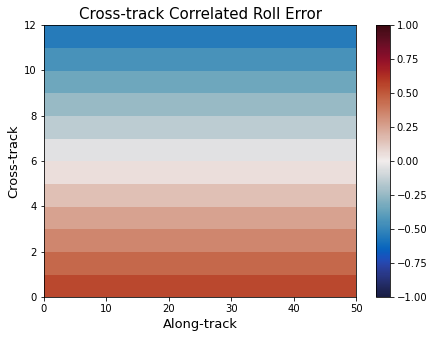

In [88]:
plt.figure(figsize = (7, 5))
plt.pcolor(roll_err, cmap = cmo.cm.balance, vmin = -1, vmax = 1)
plt.colorbar()
plt.xlabel('Along-track', fontsize = 13)
plt.ylabel('Cross-track', fontsize = 13)
plt.title('Cross-track Correlated Roll Error', fontsize = 15)
plt.savefig('Cross_track_Correlated_Roll_Error.png', dpi = 100)

In [89]:
roll_err_masked = np.ma.MaskedArray(roll_err, y_mask)
xc_masked = np.ma.MaskedArray(xc, y_mask)

In [90]:
roll_err_valid = roll_err_masked.compressed().astype(int) # retrieve the valid data 
xc_valid = xc_masked.compressed().astype(int) # retrieve the valid data 
roll_err_valid.shape

(440,)

#### Add roll error to SSH

In [91]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v = np.zeros([N, M+1]) # M: number of model
nx, ny = N, N
for iii in range(N):
    #print(xvalid_index[iii], yvalid_index[iii])
    IIndex[iii] = nx * ny * tindex[iii] + ny * xvalid_index[iii] + yvalid_index[iii]
    Y_v[iii] = SSH_XYT[tindex[iii], xvalid_index[iii], yvalid_index[iii]] + roll_err_valid[iii]
    H_v[iii, -1] = xc_valid[iii] # distance from nadir Xc 
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            H_IIndex = nx * ny * tindex[iii] + ny * xvalid_index[iii] + yvalid_index[iii] ## Data space
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[tindex[iii], xvalid_index[iii], yvalid_index[iii], mm, nn]
            H_v[iii, JIndex + 1] = H_sin[tindex[iii], xvalid_index[iii], yvalid_index[iii], mm, nn]

#### Weighted least square solution

#### R and P Matrix

In [92]:
R_ = np.eye(N, N)

In [93]:
P_ = np.eye(M+1, M+1)

In [94]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M+1):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [95]:
A = np.matmul(H_v.T, LA.inv(R_))

In [96]:
HRH = np.matmul(A, H_v)

In [97]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

In [98]:
HRH.shape, LA.inv(P_).shape

((31, 31), (31, 31))

In [99]:
eig, vec = LA.eig(HRH)
eig.real

array([3.64888292e+05, 2.47873864e+04, 2.27373593e+04, 1.58925133e+04,
       1.89382687e+04, 1.72823488e+04, 1.82172834e+04, 6.27081475e+03,
       5.89843785e+03, 5.79546768e+03, 5.29544858e+03, 4.87836356e+03,
       4.12364517e+03, 4.16162163e+03, 3.68554238e+03, 3.85914056e+03,
       3.80413017e+03, 9.92720846e+01, 1.09390142e+02, 1.76260718e+03,
       1.71811004e+03, 1.74845515e+03, 1.53097408e+03, 1.41653810e+03,
       1.28932239e+03, 7.72336142e+02, 7.27194373e+02, 6.87042686e+02,
       5.88451287e+02, 6.08799552e+02, 6.41944355e+02])

#### Soution with noise

In [100]:
X_ = np.matmul(D, Y_v)

In [101]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

In [102]:
AMP_alpha2 = np.append(Amp.reshape([30], order = 'F'), alpha2)

In [105]:
AMP_alpha2[-1], SOL_WN[-1], SOL_WN[-1] - AMP_alpha2[-1]

(-1e-05, -9.880113586024572e-06, 1.198864139754288e-07)

In [106]:
AMP_alpha2[:], SOL_WN[:]

(array([ 6.51058181e-01,  4.15941924e-01,  3.77640256e-01,  6.38637906e-03,
         3.19208385e-01,  4.77511998e-01,  1.61758268e-01,  8.47377622e-01,
         5.19012373e-01,  1.27369722e-01,  3.37871000e-01,  5.48758415e-01,
         6.73864108e-01,  8.73077383e-01,  8.77858035e-01,  2.33239822e-01,
         7.85021585e-01,  9.72709905e-01,  9.19631474e-01,  3.35428555e-01,
         7.80220279e-01,  3.44849605e-01,  4.47075670e-01,  2.52765277e-03,
         5.26635286e-01,  2.75249749e-01,  1.76590124e-01,  2.51536729e-01,
         6.74653485e-01,  9.31178852e-01, -1.00000000e-05]),
 array([ 6.51016135e-01,  4.15933753e-01,  3.77534086e-01,  6.39184536e-03,
         3.19126645e-01,  4.77449368e-01,  1.61609581e-01,  8.46804114e-01,
         5.17988177e-01,  1.27070992e-01,  3.37824976e-01,  5.48706768e-01,
         6.73660815e-01,  8.72807893e-01,  8.77578181e-01,  2.33186782e-01,
         7.84543177e-01,  9.71983094e-01,  9.18329843e-01,  3.34546219e-01,
         7.76235497e-01,  3

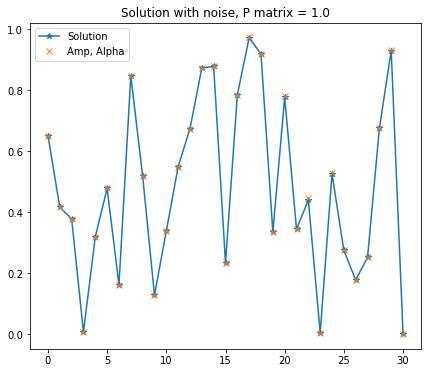

In [107]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN,'*-', label = 'Solution')
plt.plot(AMP_alpha2,'x',label = 'Amp, Alpha')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'_alpha2Xc.png')

In [108]:
diff = SOL_WN - AMP_alpha2

In [109]:
rms = np.sqrt(np.mean(diff**2))
rms

0.001689621898030625